# Load model
Our best model is a TrOCR model we for convenience uploaded to huggingface.  
It has a Spanish language base model and is fine-tuned on the hackathon dataset.  
Read more in [our report](https://docs.google.com/document/d/1D-7LCVOQwUMZ3FuOWiORKHvNWNT5eDkYGrEC1H8ul_U/edit?usp=sharing)

In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("MarieRoald/DeepLearn24OCRChallenge").to(device)
model.generation_config.max_length = 128
model.generation_config.early_stopping = False

processor = TrOCRProcessor.from_pretrained("MarieRoald/DeepLearn24OCRChallenge")

2024-07-29 13:42:50.718362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-29 13:42:50.802577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-29 13:42:50.802638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-29 13:42:50.804869: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-29 13:42:50.817793: I tensorflow/core/platform/cpu_feature_guar

# Load test data
Loading our line-level data from our github repo

In [2]:
import pandas as pd

metadata_df = pd.read_csv("../data/2_bounding_box/Doc-UFCN_processed/metadata.csv")

test_df = metadata_df[metadata_df.split == "test"]
test_df.sort_values("file_name")
test_df.index = range(len(test_df))
test_df

,file_name,spread_number,spread_side,split,line_number,transcription,x,y,w,h
0,test/image_14_left_001.png,14,left,test,1,NaN,120,40,361,38
1,test/image_14_left_002.png,14,left,test,2,NaN,88,69,389,39
2,test/image_14_left_003.png,14,left,test,3,NaN,87,98,390,40
3,test/image_14_left_004.png,14,left,test,4,NaN,86,127,389,39
4,test/image_14_left_005.png,14,left,test,5,NaN,85,158,392,37
...,...,...,...,...,...,...,...,...,...,...
137,test/image_16_right_044.png,16,right,test,44,NaN,21,603,389,33
138,test/image_16_right_045.png,16,right,test,45,NaN,22,637,389,28
139,test/image_16_right_046.png,16,right,test,46,NaN,21,663,380,32
140,test/image_16_right_047.png,16,right,test,47,NaN,23,691,350,34


In [3]:
from pathlib import Path
from tqdm import trange
from PIL import Image

test_set_path = Path("../data/2_bounding_box/Doc-UFCN_processed/")
test_images = test_df.file_name.apply(lambda file_name: test_set_path / file_name).apply(Image.open).to_list()

pixel_values = processor(test_images, return_tensors="pt")["pixel_values"].to(device)
estimated_tokens = [model.generate(pixel_values[i].unsqueeze(0)) for i in trange(len(test_images))]
test_df["prediction"] = [
    processor.batch_decode(estimated_tokens[i], skip_special_tokens=True)[0]
    for i in trange(len(test_images))
]

100%|██████████| 142/142 [00:00<00:00, 10364.60it/s]
/tmp/ipykernel_24199/1770123056.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["prediction"] = [


In [4]:
test_output = Path("../data/best_model_test_predictions/")
test_output.mkdir(exist_ok=True, parents=True)

test_df.to_csv(test_output / "predictions.csv", index=False)

# Concat model outputs to page data
Each `image_<number>_prediction.txt` file corresponds to `imgsForAllPages/image_<number>.png` in the handout data.  
`all_text.txt` contains the predicted text for all test pages concatenated with newline 

In [5]:
handout_data_page_start = 26
current_page = handout_data_page_start
all_texts = ""

for spread, df_ in test_df.groupby("spread_number"):
    assert df_["spread_side"].to_list()[0] == "left" and df_["spread_side"].to_list()[-1] == "right"
    for side, df__ in df_.groupby("spread_side"):
        page_text = "\n".join(df__.prediction)
        with open(test_output / f"image_{current_page}_prediction.txt", "w+") as f:
            f.write(page_text)
        current_page += 1
        all_texts += page_text + "\n"
    
with open(test_output / "all_text.txt", "w+") as f:
    f.write(all_texts)

# Inspect data 

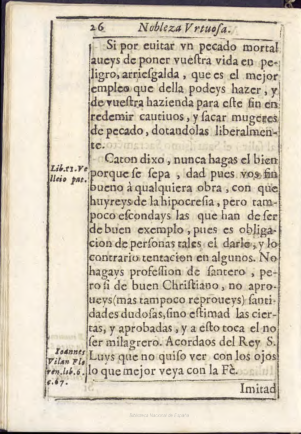

Si por evitar un pecado mortal 
aveys de poner vuestra vida en pe-
ligro, arriesgalda, que es el mejor 
empleo que della podeys hazer, y 
de vuestra hazienda para este sin en
redemir cautivos, y sacar mugetes 
de pecado, dotandolas liberalmen-
Caton dixo, nunca hagas el bien
porque se sepa, dad pues vos sin
bueno a cualquiera obra, con que 
huyreys de la hipocresia, pero tam-
poco escondays las que han de ser
de buen exemplo, pues es obliga-
cion de personas tales el darle, y lo
contrario tentacion en algunos. No 
hagays profession de santero, pe-
ro si de buen Christiano, no apro-
veys (más tampoco repromeys) santi-
dades dudosas, sino estimad las cier-
tas, y aprobadas, e a esto toca el no 
ser milagrero. A cordaos del Rey S.
Luys que no quiso ver con los ojos
lo que mejor veya con la Fe-




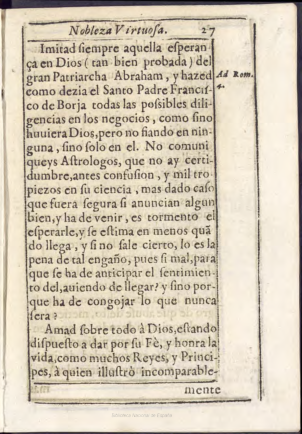

Imitad siempre aquella esperan 
sa en Dios (tan bien probada) del 
gran Patriarcha Abraham, y hazed-
como dezia el Santo Padre Francis-
co de Borja todas las possiblees dili-
gencias en los negocios, como sino 
huviera Dios, pero no siando en ni-
guna, sino solo en el. No comuni
queys Astrologos, que no ay certi-
dumbre, antes confusion, y mil tro-
piezos en su ciencia, más dado caso 
que fuera segura si anuncian algun
bien, y ha de venir, es tormento el 
esperarle, y se estima en menos quá
do llega, y si no sale cierto, lo es la 
pena de tal engaño, pues si mal, para 
que se ha de anticipar el sentimien-
to del, aviendo de llegar? y sino por-
que ha de congojar lo que nunca 
Amad sobre todo a Dios, estando 
dispuesto a dar por su Fe, y honra la 
vida, como muchos Reyes, y Princi-
pes, a quien illustro incomparable-




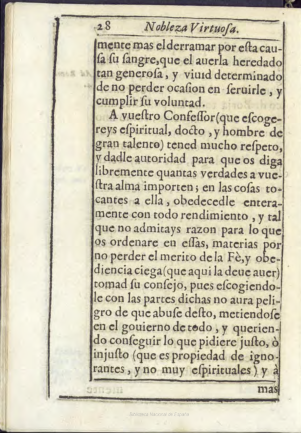

mente mas el derramar por esta cau-
sa su sangre, que el averla heredado 
tan generosa, y vivid determinado 
de no perder ocasion en servirle, y 
cumplir su voluntad. 
A vuestro Confessor(que escoge-
reys espiritual, docto, y hombre de 
gran talento) tened mucho respeto, 
y dadle autoridad para que os diga 
libremente quantas verdades a vue-
stra alma importen; en las cosas to-
cantes a ella, obedecedle entera-
mente con todo rendimiento, y tal
que no admitays razon para lo que 
os ordenare en esfas, materias por 
no perder el merito de la Fe, y obe-
diencia ciega (que aqui la deve aver) 
tomad su consejo, pues escogiendo-
le con las partes dichas no aura peli-
gro de que abuse desto, metiendose 
en el guierno de todo, y querien-
do conseguir lo que pidiere justo, o 
injusto (que es propiedad de igno-
rantes, y no muy espirituales) y a 




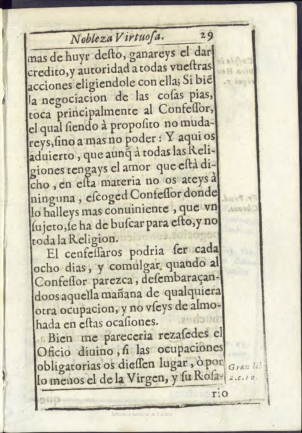

más de huyr desto, ganareys el dar
credito, y autoridad a todas vuestras 
acciones eligiendole con ella; Si bi-
la negociacion de las cosas pias, 
toca principalmente al Confessor, 
el qual siendo a proposito no muda-
reys, sino a mas no poder: Y aqui os 
adquierto, que aunq a todas las Reli-
giones tengays el amor que esta di-
cho, en esta materia no os ateys a 
ninguna, escoged Contestor donde 
lo halleys más conviniente, que un
sujeto, se ha de buscar para esto, y no 
toda la Religion. 
El censessaros podria ser cada 
ocho días, y comulgar, quando al 
Confessor parezca, desembarazan-
doos aquella mañana de cualquiera 
otra ocupacion, y no veys de almo-
hada en estas ocasiones. 
Bien me pareceria rezasedes el 
Oficio divino, si las ocupaciones 
obligatorias os diesen lugar, o por
lo menos el de la Virgen, y su Rosa-




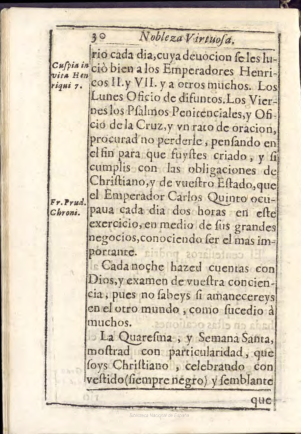

río cada dia, cuya devocion se les su-
cio bien a los Emperadores Henri-
cos 11. y VII, y a otros muchos. Los 
Lunes Oficio de difuntos. Los Vier-
nes los PSalmos Penitenciales, y Ofi-
cio de la Cruz, y un rato de oracion, 
procurad no perderle, pensando en 
el fin para que fuystes criado, y si
cumplis con las obligaciones de 
Christiano, y de vuestro Estado, que 
el Emperador Carlos Quinto ocu-
pava cada dia dos horas en este 
exercicio, en medio de sus grandes 
negocios, conociendo ser el mas im-
portante. 
Cada noche hazed cuentas con 
Dios, y examen de vuestra concien-
cia, pues no sabeys si amanecereys 
en el otro mundo, como fucedio a 
muchos.
La Quaresma, y Semana Santa, 
mostrad con particularidad, que 
soys Christiano, celebrando con 
vestido (siempre negro) y semblante 




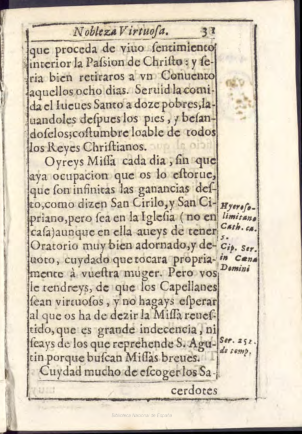

que proceda de vivo sentimiento 
interior la Passion de Christo: y se 
ría bien retiraros a un Convento 
aquellos ocho dias. Servid la comi-
da el Iveues Santo a doze pobres, la 
vandoles despues los pies, y besan-
doselos; costumbre loable de todos 
los Reyes Christianos. 
Dyreys Missa cada dia, sin que 
aya ocupacion que os lo estorue, 
que son infinitas las ganancias des-
to, como dizen San Cirilo, y San Ci-
priano, pero sea en la Iglesia (no en
casa) aunque en ella aveys de tener
Oratorio muy bien adornado, y de-
voto, cuydado quetocara propria-
mente a vuestra mujger. Pero vos
le tendreys, de que los Capellanes 
sean virtuosos, y no hagays esperar
al que os ha de dezir la Missa renes-
tido, que es grande indecencia, ni
seays de los que reprehende S. Agu
tin porque buscan Misslas breves
Cuydad mucho de escoger los Sa-




In [6]:
from PIL import Image
page_images = sorted([e for e in Path("../data/0_input/handout-created/imgsForAllPages").iterdir() if int(e.stem.split("_")[-1]) >= handout_data_page_start])
transcriptions = sorted([e for e in test_output.iterdir() if e.suffix == ".txt" and "prediction" in e.name])

for img, transcription in zip(page_images, transcriptions):
    img = Image.open(img)
    display(img)

    print(transcription.read_text())
    print("\n")